# Generative Adversarial Networks

Added spectral normalization like: https://github.com/minhnhat93/tf-SNDCGAN

In [1]:
import numpy as np
import tensorflow as tf
from libs.sn import spectral_normed_weight

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load data

(6707, 1000)


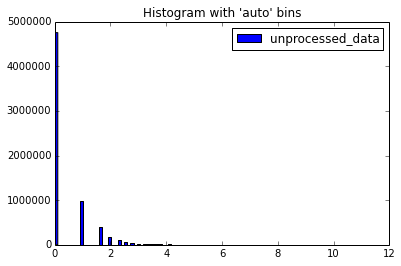

In [2]:
from numpy import genfromtxt
#kasper_rank_matrix = genfromtxt('kasper_data_rank_normalised_top784_norownames.csv', delimiter=',', skip_header=1)
#kasper_rank_matrix = genfromtxt('kasper_data_raw_top784_v2.csv', delimiter=',', skip_header=1)

kasper_rank_matrix = genfromtxt('kasper_data_raw_full.csv', delimiter=',', skip_header=1)

#only use first 1000 cells
kasper_rank_matrix_unwitheld = kasper_rank_matrix
kasper_rank_matrix = kasper_rank_matrix[:,0:1000]

print(kasper_rank_matrix.shape)

import matplotlib.pyplot as plt
kasper_unprocessed_hst = np.hstack(kasper_rank_matrix)

plt.hist(kasper_unprocessed_hst, bins=100, label='unprocessed_data') # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
pyplot.legend(loc='upper right')
plt.show()


### Parameters

In [3]:
n_train_steps = 30
batch_size = 256 #originally 128

noise_input_size = 100
inflate_to_size = 600
gex_size = 6707

disc_internal_size = 200

### Generator network

In [4]:
def lrelu(x):
    return tf.maximum(x, 0.2 * x)

z = tf.placeholder(tf.float32, shape=(None, noise_input_size))
g_w1 = tf.get_variable("g_w1", [noise_input_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                      regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b1 = tf.get_variable("g_b1", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w2 = tf.get_variable("g_w2", [inflate_to_size,inflate_to_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b2 = tf.get_variable("g_b2", [inflate_to_size], initializer=tf.constant_initializer(0.1))
g_w3 = tf.get_variable("g_w3", [inflate_to_size, gex_size], initializer=tf.random_uniform_initializer(-0.05, 0.05),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
g_b3 = tf.get_variable("g_b3", [gex_size], initializer=tf.constant_initializer(0.1))

g_params = [g_w1, g_b1, g_w2, g_b2, g_w3, g_b3]

def generator(z):
    g_y1 = lrelu(tf.matmul(z, g_w1) + g_b1)
    g_y2 = lrelu(tf.matmul(g_y1, g_w2) + g_b2)
    G = tf.nn.relu(tf.matmul(g_y2, g_w3) + g_b3)
    
    #tensorboard
    tf.summary.histogram('layer1/g_y1', g_y1)
    tf.summary.histogram('layer2/g_y2', g_y2)
    tf.summary.histogram('layer3/out', G)
    return G

### Latent vector / noise input

Poisson noise (count data) + Gaussian (other artefacts)

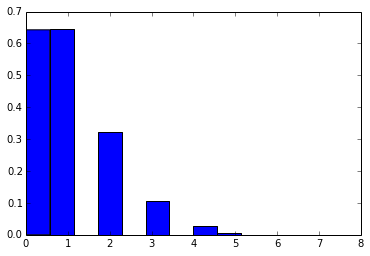

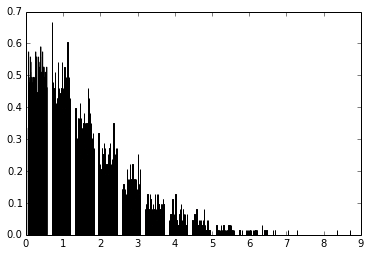

In [22]:
#changed so that max value in noise generation prior is max value of data

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 14, normed=True)
plt.show()

data_max_value = numpy.amax(kasper_rank_matrix)

def noise_prior(batch_size, dim):
    temp_norm = np.random.normal(0.0, data_max_value/10, size=(batch_size, dim))
    temp_poisson = np.random.poisson(1, size=(batch_size, dim))
    return np.abs(temp_norm + temp_poisson)

        
example_noise_batch = noise_prior(100, 100)
count, bins, ignored = plt.hist(example_noise_batch, 14, normed=True)
plt.show()


### Discriminator network

In [6]:
x = tf.placeholder(tf.float32, shape=(None, gex_size))
d_w1 = tf.get_variable("d_w1", [gex_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005, 0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b1 = tf.get_variable("d_b1", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w2 = tf.get_variable("d_w2", [disc_internal_size,disc_internal_size], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b2 = tf.get_variable("d_b2", [disc_internal_size], initializer=tf.constant_initializer(0.1))
d_w3 = tf.get_variable("d_w3", [disc_internal_size,1], initializer=tf.random_uniform_initializer(-0.005,0.005),
                       regularizer=tf.contrib.layers.l2_regularizer(0.8))
d_b3 = tf.get_variable("d_b3", [1], initializer=tf.constant_initializer(0.1))

d_params = [d_w1, d_b1, d_w2, d_b2, d_w3, d_b3]

clip_d = None

def discriminator(x):
    
    d_y1 = lrelu(tf.matmul(x, d_w1) + d_b1)
    d_y2 = lrelu(tf.matmul(d_y1, d_w2) + d_b2)
    D = tf.matmul(d_y2, d_w3) + d_b3

    weights_d1 = tf.summary.histogram('d_layer1/d_w1_bar', d_w1)
    weights_d2 = tf.summary.histogram('d_layer2/d_w2_bar', d_w2)
    weights_d3 = tf.summary.histogram('d_layer3/d_w3_bar', d_w3)

    bias_d1 = tf.summary.histogram('d_layer1/d_b1', d_b1)
    bias_d2 = tf.summary.histogram('d_layer2/d_b2', d_b2)
    bias_d3 = tf.summary.histogram('d_layer3/d_b3', d_b3)

    tf.summary.histogram('d_layer1/d_y1', d_y1)
    tf.summary.histogram('d_layer2/d_y2', d_y2)
    tf.summary.histogram('d_layer3/D', D)
    
    return D



Define the outputs we're going to train.

In [7]:
G = generator(z)
D_real = discriminator(x)
D_fake = discriminator(G)

### Training Objectives

Changed for Wasserstein distance/objectives and added gradient penalty.
NB: Need to tune parameter LAMBDA

In [9]:
LAMBDA = 10 # Gradient penalty lambda hyperparameter

obj_d = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real)
obj_g = -tf.reduce_mean(D_fake)

##### need to expand shape of alpha?

alpha = tf.random_uniform(
    shape=[batch_size,gex_size], 
    minval=0.,
    maxval=1.
)

differences = D_fake - D_real
interpolates = D_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
obj_d += LAMBDA*gradient_penalty

In [10]:
def exp_decay(initial_rate, step, decay_factor, min_lr):
    return tf.maximum(initial_rate / tf.pow(decay_factor, tf.to_float(step)), min_lr)

def momentum_adjustor(initial_momentum, step, final_momentum, saturation_point):
    m = initial_momentum + (final_momentum - initial_momentum) * (tf.to_float(step) / saturation_point)
    return tf.minimum(m, final_momentum)

time_step = tf.placeholder(tf.int32)

d_batch = tf.Variable(0, trainable=False)
d_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
d_momentum = momentum_adjustor(0.5, d_batch, 0.7, 250)
#opt_d = tf.train.MomentumOptimizer(d_learning_rate, d_momentum).minimize(obj_d, var_list=d_params, global_step=d_batch)
opt_d = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_d, var_list=d_params)

g_batch = tf.Variable(0, trainable=False)
g_learning_rate = exp_decay(0.01, time_step, 1.000004, 0.000001)
g_momentum = momentum_adjustor(0.5, g_batch, 0.7, 250)
#opt_g = tf.train.MomentumOptimizer(g_learning_rate, g_momentum).minimize(obj_g, var_list=g_params, global_step=g_batch)
opt_g = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(obj_g, var_list=g_params)

d_momentum_summary = tf.summary.scalar('d_momentum', d_momentum)
g_momentum_summary = tf.summary.scalar('g_momentum', g_momentum)
d_learning_rate_summary = tf.summary.scalar('d_learning_rate', d_learning_rate)
g_learning_rate_summary = tf.summary.scalar('g_learning_rate', g_learning_rate)
obj_d_summary = tf.summary.scalar('obj_d', obj_d)
obj_g_summary = tf.summary.scalar('obj_g', obj_g)

weights_g1 = tf.summary.histogram('layer1/g_w1', g_w1)
weights_g2 = tf.summary.histogram('layer2/g_w2', g_w2)
weights_g3 = tf.summary.histogram('layer3/g_w3', g_w3)

bias_g1 = tf.summary.histogram('layer1/g_b1', g_b1)
bias_g2 = tf.summary.histogram('layer2/g_b2', g_b2)
bias_g3 = tf.summary.histogram('layer3/g_b3', g_b3)


### Training

In [12]:
n_train_steps = 20

initial_run = True
model_to_use = "./models/SN-WGAN-GP_v1.ckpt"

global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)

sess=tf.InteractiveSession()
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("./summaries/SN-WGAN-GP_v1", sess.graph)
saver = tf.train.Saver()
init = tf.global_variables_initializer().run()

if initial_run:
    print("Initial run")
    assign_step_zero = tf.assign(global_step, 0)
    init_step = sess.run(assign_step_zero)
    
if not initial_run:
    saver.restore(sess, model_to_use)

for i in range(n_train_steps):
    #increment global step
    increment_global_step_op = tf.assign(global_step, global_step+1)
    step = sess.run(increment_global_step_op)
    
    current_step = sess.run(global_step)
    
    #replace below with our data
    #x_data, t_data = mnist.train.next_batch(batch_size)
    idx = np.random.randint(kasper_rank_matrix.shape[1], size=batch_size)

    x_data = kasper_rank_matrix[:,idx]
    x_data = np.transpose(x_data)
    
    noise = noise_prior(batch_size, 100)
    
    #train discriminator more
    for j in range(5):
        _, summary = sess.run([opt_d, merged], {x : x_data, z : noise, time_step : current_step})
        train_writer.add_summary(summary, current_step)
        
    sess.run([opt_g], {z : noise, time_step : current_step})
    
    if i % (n_train_steps/10) == 0:
        print str(float(i)/n_train_steps) + " No. steps: " + str(current_step)
        intermediate_save_path = saver.save(sess, model_to_use, global_step=current_step)

save_path = saver.save(sess, model_to_use)
print("Model saved in file: %s" % save_path)

Initial run
0.0 No. steps: 1
0.1 No. steps: 3
0.2 No. steps: 5
0.3 No. steps: 7
0.4 No. steps: 9
0.5 No. steps: 11
0.6 No. steps: 13
0.7 No. steps: 15
0.8 No. steps: 17
0.9 No. steps: 19
Model saved in file: ./models/SN-WGAN-GP_v1.ckpt


### IMPROVEMENTS
1. How can we encourage output diversity?
Introduce metric like mutual information? Also want replicates... don't want only random noise output

### Generate cells after training

In [13]:
#Generate 100 cells

gen_cells = sess.run(G, {z : noise_prior(1, 100)})

for cell in range(0,499):
    out_gen_temp = sess.run(G, {z : noise_prior(1, 100)})
    gen_cells = numpy.append(gen_cells, out_gen_temp, axis=0)

gen_cells = gen_cells

print(gen_cells)

[[ 0.02118354  0.29054052  0.06983618 ...,  0.          0.          0.06414319]
 [ 0.          0.18146288  0.09872191 ...,  0.          0.          0.        ]
 [ 0.13324983  0.21247384  0.         ...,  0.          0.          0.18453041]
 ..., 
 [ 0.          0.05195437  0.19492951 ...,  0.          0.          0.27465633]
 [ 0.08467586  0.06577779  0.24459353 ...,  0.          0.          0.13367666]
 [ 0.03910808  0.2211208   0.13846901 ...,  0.          0.04907172
   0.1945115 ]]


### Examine correlations between gen. cells and real cells

(1000, 1000)
(500, 500)


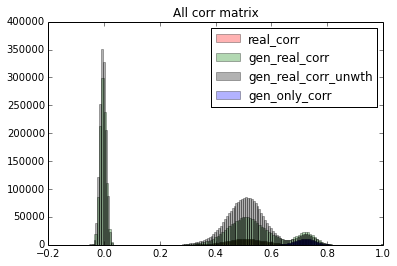

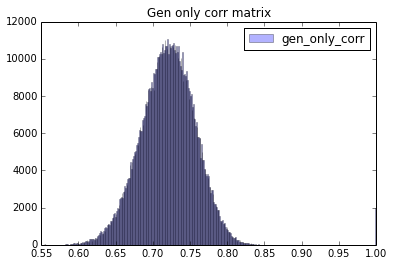

In [18]:
import matplotlib.pyplot as plt
kasper_corr_mat = numpy.corrcoef(np.transpose(kasper_rank_matrix))
gen_corr_mat = numpy.corrcoef(gen_cells)

print(kasper_corr_mat.shape)
print(gen_corr_mat.shape)

kasper_hst = np.hstack(kasper_corr_mat)
gen_hst = np.hstack(gen_corr_mat)

#generated cells vs real cells
gen_real_corr_mat = np.corrcoef(gen_cells, np.transpose(kasper_rank_matrix))
gen_real_corr_mat_hst = np.hstack(gen_real_corr_mat)

#generated cells vs real cells including unwitheld
gen_real_corr_mat_unwitheld = np.corrcoef(gen_cells, np.transpose(kasper_rank_matrix_unwitheld))
gen_real_corr_mat_unwitheld_hst = np.hstack(gen_real_corr_mat_unwitheld)

#generated cells vs generated cells
gen_only_corr_mat = np.corrcoef(gen_cells, gen_cells)
gen_only_hst = np.hstack(gen_only_corr_mat)

plt.hist(kasper_hst, bins='auto', alpha=0.3, label='real_corr', color="red")
plt.hist(gen_real_corr_mat_hst, bins='auto', alpha=0.3, label='gen_real_corr', color="green") # arguments are passed to np.histogram
plt.hist(gen_real_corr_mat_unwitheld_hst, bins='auto', alpha=0.3, label='gen_real_corr_unwth', color="black") # arguments are passed to np.histogram
plt.hist(gen_only_hst, bins='auto', alpha=0.3, label='gen_only_corr', color="blue") # arguments are passed to np.histogram
plt.title("All corr matrix")
pyplot.legend(loc='upper right')
savefig("correlation_histogram.pdf")
plt.show()

#plt.hist(kasper_hst, bins='auto', alpha=0.3, label='real_corr')
#plt.hist(gen_hst, bins='auto', alpha=0.3, label='gen_real_corr') # arguments are passed to np.histogram
#plt.hist(gen_only_hst, bins='auto', alpha=0.3, label='gen_only_corr') # arguments are passed to np.histogram
#plt.title("All corr matrix")
#pyplot.legend(loc='upper right')
#plt.show()

plt.hist(gen_only_hst, bins='auto', alpha=0.3, label='gen_only_corr') # arguments are passed to np.histogram
plt.title("Gen only corr matrix")
pyplot.legend(loc='upper right')
plt.show()


### Compare input (z) dist. and output dist.

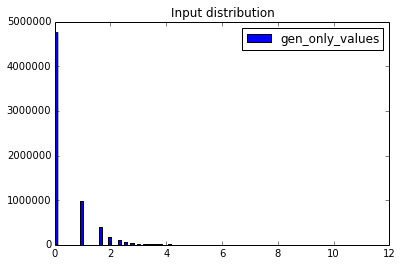

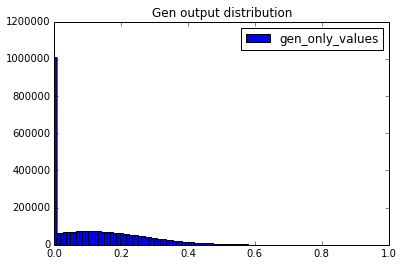

In [23]:
input_dist = np.hstack(numpy.ndarray.flatten(kasper_rank_matrix))

plt.hist(input_dist, bins=100, label='gen_only_values') # arguments are passed to np.histogram
plt.title("Input distribution")
pyplot.legend(loc='upper right')
plt.show()

gen_output_dist = np.hstack(numpy.ndarray.flatten(gen_cells))

plt.hist(gen_output_dist, bins=100, label='gen_only_values') # arguments are passed to np.histogram
plt.title("Gen output distribution")
pyplot.legend(loc='upper right')
plt.show()

### tSNE to compare real and gen. cells

In [ ]:
#Calc tSNE
from sklearn.manifold import TSNE
n_genes_cov = 500

X = np.transpose(kasper_rank_matrix_unwitheld)

data_cov = numpy.var(kasper_rank_matrix_unwitheld, axis=1)/numpy.mean(kasper_rank_matrix_unwitheld, axis=1)
data_cov_index_desc = data_cov.argsort()[::-1][:n_genes_cov]

print(X.shape)
X = np.append(X, gen_cells, axis=0)
X = X[:,data_cov_index_desc]
print(X.shape)

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
combined_tsne = model.fit_transform(X)


In [ ]:
#Plot tSNE
import matplotlib.cm as cm

print(combined_tsne.shape)

num_kasper_cells = kasper_rank_matrix_unwitheld.shape[1]
num_gen_cells = gen_cells.shape[0]

print(num_kasper_cells)
print(num_gen_cells)
print(num_kasper_cells-1000)

#tsne_color = np.append(np.repeat("blue",1000), np.repeat("green",422), np.repeat("red",num_gen_cells))
tsne_color = np.concatenate([np.repeat("red",1000), np.repeat("green",422), np.repeat("blue",num_gen_cells)])
print(tsne_color.shape)
plt.scatter(combined_tsne[:,0],combined_tsne[:,1], c=tsne_color)
plt.show()

### Visualise expression using heatmaps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(kasper_rank_matrix.shape)

import seaborn as sns; sns.set()
g = sns.clustermap(np.transpose(X))

g = sns.clustermap(np.transpose(gen_cells[:,data_cov_index_desc]))